In [ ]:
# landau-bee-data-analysis.ipynb
#
# Bryan Daniels
# 2021/9/3
# 2023/4/10 renamed
#
# Analysis of Landau procedure applied to honeybee expression data.
#
# Combining code from compare-landau-and-gaussian.ipynb, test-landau.ipynb
#

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from landauAnalysis import landauAnalysis,principalComponents,gaussianMixtureAnalysis
from landauAnalysis import LandauTransitionDistributionRelativeLogPDF
from runFittingAnalysis import loadBeeData

from toolbox import setDefaultParams,makePretty,load
setDefaultParams()

In [8]:
def bistablePlot(finalStates,vec,Jvals,Jvecs,c,d,nuMu,returnData=False,plotTheory=True,plotGaussian=True,
                **histKwargs):
    
    # calculate projection along eigenvector
    
    if (len(vec) == 1) and (finalStates.shape[1] > 1):
        # compute principal eigenvector manually if we're given a vec from a projected analysis
        PCAvals,PCAvecs = principalComponents(finalStates)
        projVec = PCAvecs[0]
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = np.mean(x)
    else:
        projVec = vec
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = sampleMean
    
    
    # plot histogram of data
    plt.hist(x,density=True,bins=30,**histKwargs)

    if plotTheory:
        # plot inferred relative log-likelihood
        xRange = 1.5*(x.max() - x.min())
        plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,xRange=xRange)
        
    if plotGaussian:
        # compare to Gaussian null model
        xVals = np.linspace(-xRange/2.,xRange/2.,500)
        distGaussian = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                            meanFinalState + xVal*vec,   
                            meanFinalState,
                            Jvals,
                            Jvecs,
                            vec,
                            1.,
                            0.)) for xVal in xVals ]
        distGaussian = distGaussian / (np.sum(distGaussian)*(np.diff(xVals)[0]))
        plt.plot(xVals,distGaussian,lw=2,color='black',label='Gaussian mixture fit')

    plt.xlabel('Gene expression\nalong bistable dimension')
    plt.ylabel('Probability')

    if returnData:
        return {'x': x,
                'vec': vec,
                'mu': mu,
                'runIndex': runIndex,
                'meanFinalState': meanFinalState,
                }

In [9]:
# bistablePlot code modified from test-landau.ipynb
def bistablePlot_fromDataDict(df,dataDict,runIndex,muIndex,returnData=False,offset=0,**kwargs):
    
    d = df
    dd = dataDict
    mu = d['mu'].unique()[muIndex]
    landauData = dd[(runIndex,offset)][mu]['landauAnalysis']
    
    dSeries = d[(d['runIndex']==runIndex) & (d['mu']==mu)]

    bistableIndex = int(dSeries['bistable index'].iloc[0])
    vec = np.real_if_close( landauData['vecList'][bistableIndex] )

    finalStates = dd[(runIndex,offset)][mu]['finalStates']
    
    Jvals = landauData['valList']
    Jvecs = np.real_if_close( landauData['vecList'] )
    cVal = landauData['cList'][bistableIndex]
    dVal = landauData['dList'][bistableIndex]
    nuMuVal = landauData['nuMuList'][bistableIndex]

    data = bistablePlot(finalStates,vec,Jvals,Jvecs,cVal,dVal,nuMuVal,returnData=returnData,**kwargs)
    
    print("c = {}; d = {}".format(cVal,dVal))
    print("mu = {}; bic diff = {}".format(mu,dSeries['bistable bic diff'].iloc[0]))
    print("Landau transition identified = {}".format(dSeries['landau transition identified'].iloc[0]))
    
    if returnData:
        return data

In [10]:
def plotLandauTheory_fromDict(landauAnalysis,bistableIndex=0,**kwargs):
    vec = landauAnalysis['vecList'][bistableIndex]
    Jvals = landauAnalysis['valList']
    Jvecs = landauAnalysis['vecList']
    c = landauAnalysis['cList'][bistableIndex]
    d = landauAnalysis['dList'][bistableIndex]
    nuMu = landauAnalysis['nuMuList'][bistableIndex]
    
    plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,**kwargs)

In [11]:
def plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,color='crimson',lw=5,zorder=10,xRange=20):
    """
    (x = 0 corresponds to the mean value along the projected axis)
    """
    xVals = np.linspace(-xRange/2.,xRange/2.,500)

    dist = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                        xVal*vec,   
                        nuMu*vec,
                        Jvals,
                        Jvecs,
                        vec,
                        c,
                        d)) for xVal in xVals ]
    dist = dist / (np.sum(dist)*(np.diff(xVals)[0]))
    plt.plot(xVals,dist,lw=lw,color=color,zorder=zorder,label='Landau fit')

# 1) bee data

## load data

In [42]:
beeData = loadBeeData()

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [43]:
ages = list(beeData.keys())

## run analysis on all bee data

In [14]:
from landau.runFittingAnalysis import runFitting

In [15]:
loadFromFile = True
if loadFromFile:
    dataDictDict = load('FittingData_bee.dat')
else:
    dataDictDict = runFitting(numNuMax=1)

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.2. This might lead to br

In [16]:
dataDictDict[1]['landauAnalysis'].keys()

dict_keys(['valList', 'vecList', 'llList', 'cList', 'dList', 'nuMuList', 'bicDiffList', 'landauTimeMinutes', 'numNuMax', 'sampleMean', 'gitHash'])

In [17]:
for age in dataDictDict.keys():
    print("At age {} days, Landau bicDiff = {}, llRatio = {}".format(age,
                                        dataDictDict[age]['landauAnalysis']['bicDiffList'][0],
                                        dataDictDict[age]['landauAnalysis']['llList'][0]))
    print("At age {} days, Gaussian n=2 bicDiff = {}".format(age,
                                        dataDictDict[age]['gaussianMixtureAnalysis1']['bicDiff']))

At age 1 days, Landau bicDiff = 2.698004207175465, llRatio = -0.037292257532158146
At age 1 days, Gaussian n=2 bicDiff = 4.903283313353626
At age 3 days, Landau bicDiff = 2.775104284644264, llRatio = 0.0012577812022414037
At age 3 days, Gaussian n=2 bicDiff = 3.7783912661460306
At age 6 days, Landau bicDiff = -3.880854824991737, llRatio = -3.326721773615759
At age 6 days, Gaussian n=2 bicDiff = -4.585761897092581
At age 10 days, Landau bicDiff = -6.292319415184984, llRatio = -4.532454068712383
At age 10 days, Gaussian n=2 bicDiff = -3.878009176235423
At age 15 days, Landau bicDiff = -10.015965938581651, llRatio = -6.394277330410716
At age 15 days, Gaussian n=2 bicDiff = -4.6810581539564


In [40]:
gsingle = dataDictDict[15]['gaussianMixtureAnalysis1']['gSingle']
gmix = dataDictDict[15]['gaussianMixtureAnalysis1']['gMultiple']
print("The single Gaussian fit has {} parameters, and the Gaussian mixture model has {} parameters.".format(
    gsingle._n_parameters(),gmix._n_parameters()))
# (The gaussian mixture model with tied covariances and 2 components has 4 parameters:
#  two means, one variance, and one relative weight of the components)
print("The Landau fit has 3 parameters (c, d, and muNu).")

The single Gaussian fit has 2 parameters, and the Gaussian mixture model has 4 parameters.
The Landau fit has 3 parameters (c, d, and muNu).


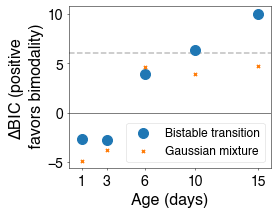

In [29]:
# NOTE: Regarding the threshold for BIC values worth mentioning,
#       - Raftery 1999 (Table 2) (corresponding to Raftery 1995 Table 6) 
#         calls BIC of 2-6 "positive evidence", 6-10 "strong", >10 "very strong" 
#       - translating to a bayes factor = exp(BIC/2), refs from wikipedia page on "bayes factor" call:
#          * 2.3 - 4.6 "substantial", 4.6 - 6.9 "strong", 6.9 - 9.2 "very strong", > 9.2 "decisive"
#          * 2.3 - 4.6 "substantial", 4.6 - 9.2 "strong", > 9.2 "decisive"

plt.figure(figsize=(4,3))

plt.scatter(ages,[ -dataDictDict[age]['landauAnalysis']['bicDiffList'][0] for age in ages],
            s=100,label='Bistable transition')
plt.scatter(ages,[ -dataDictDict[age]['gaussianMixtureAnalysis1']['bicDiff'] for age in ages],
            s=10,marker='x',label='Gaussian mixture')

plt.xticks(ages);
plt.xlabel('Age (days)')
plt.ylabel('$\Delta$BIC (positive \n favors bimodality)')
xmin,xmax = 0,16
plt.hlines(0,xmin,xmax,'k',lw=0.5)
plt.hlines(6,xmin,xmax,'0.75',ls='--',lw=1.5,zorder=-10)
plt.axis(xmin=xmin,xmax=xmax)
leg = plt.legend(loc=4)
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.25,right=0.95)
makePretty(leg)
plt.savefig('220307_BIC_vs_time.pdf')

In [101]:
# 2022/3/8 quote values of c and d at least for Days 10 and 15
for age in dataDictDict.keys():
    print("At age {} days, c = {}, d = {}".format(age,
                                        dataDictDict[age]['landauAnalysis']['cList'][0],
                                        dataDictDict[age]['landauAnalysis']['dList'][0]))

At age 1 days, c = 0.7613283963919468, d = 0.08863771004747441
At age 3 days, c = 0.9970051208031986, d = 0.0010000619358277413
At age 6 days, c = -4.09781868786189, d = 2.3513043530281927
At age 10 days, c = -4.7535875168251, d = 3.18993398982569
At age 15 days, c = -6.087015248906886, d = 4.9494006791172005


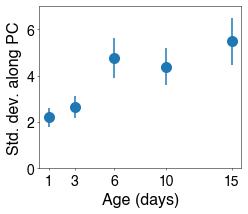

In [103]:
# 2022/4/5 plot variance along PC as a function of age
plt.figure(figsize=(4,3))

Nsamples = 16.
variances = np.array([ 1./dataDictDict[age]['landauAnalysis']['valList'][0] for age in ages])
stds = np.sqrt(variances)*np.sqrt(Nsamples)/np.sqrt(Nsamples-1)

stdOfStds = stds/np.sqrt(2.*(Nsamples-1))
plt.errorbar(ages,stds,ls='',marker='o',
            ms=10,label='Standard deviation along PC',
            yerr=stdOfStds)

plt.xticks(ages);
plt.xlabel('Age (days)')
plt.ylabel('Std. dev. along PC')
ymin,ymax = 0,7
plt.axis(ymin=ymin,ymax=ymax)
leg = None #plt.legend(loc=4)
plt.subplots_adjust(bottom=0.2,top=0.95,left=0.25,right=0.95)
makePretty(leg)
plt.savefig('220407_PC_std_dev_vs_time.pdf')

In [23]:
dataDictDict[1]['landauAnalysis'].keys()

dict_keys(['valList', 'vecList', 'llList', 'cList', 'dList', 'nuMuList', 'bicDiffList', 'landauTimeMinutes', 'numNuMax', 'sampleMean', 'gitHash'])

### 2022.2.3 order genes by fraction of variance along bistable dimension on day 15

In [19]:
day = 15 #10 #15
dayData = dataDictDict[day]['landauAnalysis']
nu = dayData['vecList'][0]
Jnu = dayData['valList'][0]
variances = np.diag(beeData[day].cov(ddof=0))

# s = fraction of variance along bistable dimension 
# nu = bistable dimension unit vector (1st principal component)
sList = nu**2 / Jnu / variances
sSeries = pd.Series(sList,index=beeData[day].columns,name='fraction of gene variance along PC')

# contribution to variance along principal component
fracVarList = nu**2
fracVarSeries = pd.Series(fracVarList,index=beeData[day].columns,name='fraction of PC variance contributed by gene')

In [20]:
# export s values
sSeries.sort_values(ascending=False).to_csv('220224_fraction_variance_along_PC_day_{}.csv'.format(day))

In [21]:
# show both fraction along bistable dimension and contribution to PC
pd.set_option('display.float_format',  '{:,.3f}'.format) # show 3 decimal places
pd.set_option('display.max_rows', 100) # show all rows
numToShow = 20
pd.concat([sSeries,fracVarSeries],axis=1).sort_values('fraction of gene variance along PC',ascending=False)[:numToShow]

,fraction of gene variance along PC,fraction of PC variance contributed by gene
vg,0.947,0.090
hex 110,0.890,0.283
P110,0.804,0.032
transferrin 1,0.804,0.019
LOC409966,0.774,0.020
Hex70a,0.768,0.095
JHE,0.745,0.031
VG protein,0.690,0.013
ilp1,0.687,0.040
Def2,0.679,0.044


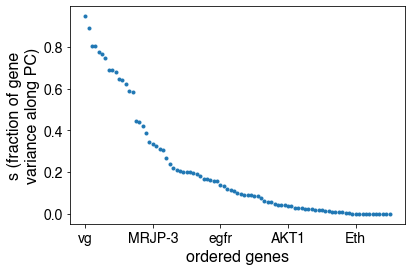

In [29]:
sSeries.sort_values(ascending=False).plot(ls='',marker='.')
plt.ylabel('s (fraction of gene\nvariance along PC)')
plt.xlabel('ordered genes');

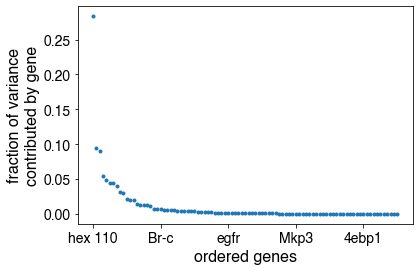

In [27]:
fracVarSeries.sort_values(ascending=False).plot(ls='',marker='.')
plt.ylabel('fraction of variance\ncontributed by gene')
plt.xlabel('ordered genes');

### 2022/4/5 compute correlations of individual genes with PC

In [ ]:
# see notes for thoughts about interpretation of these p-values...

In [22]:
import scipy.stats as stats

In [23]:
# get principal components
PCdict = dict([ (age, dataDictDict[age]['landauAnalysis']['vecList'][0]) for age in ages ])

In [24]:
agesToCompute = [10,15] # days
cutoff = 0.01 # 0.001
for age in agesToCompute:
    genes = list(beeData[age].columns)
    corrVals = [ stats.spearmanr(np.dot(beeData[age],PCdict[age]),
                                 beeData[age][gene]) for gene in genes ]
    pVals = [ stats.spearmanr(np.dot(beeData[age],PCdict[age]),
                                 beeData[age][gene])[1] for gene in genes ]
    pValsSeries = pd.Series(pVals,genes,name='spearman p-value')
    pValsSeries.sort_values(inplace=True)
    pValsSeries.to_csv('220405_gene_PC_pVals_Day_{}.csv'.format(age))
    print("Day {}:".format(age))
    print("    Cutoff of {} produces {} 'significant' genes.".format(cutoff,len(pValsSeries[pValsSeries<cutoff])))
    print()
    
    # also include s values (code modified from code found above)
    dayData = dataDictDict[age]['landauAnalysis']
    nu = dayData['vecList'][0]
    Jnu = dayData['valList'][0]
    variances = np.diag(beeData[age].cov(ddof=0))

    # s = fraction of variance along bistable dimension 
    # nu = bistable dimension unit vector (1st principal component)
    sList = nu**2 / Jnu / variances
    sSeries = pd.Series(sList,index=beeData[age].columns,name='fraction of gene variance along PC')
    
    # output dataframe with both s values and p values
    df = pd.DataFrame([sSeries,pValsSeries]).T
    df.sort_values(['fraction of gene variance along PC'],ascending=False,inplace=True)
    df.to_csv('220407_gene_PC_contributions_Day_{}.csv'.format(age))

Day 10:
    Cutoff of 0.01 produces 23 'significant' genes.

Day 15:
    Cutoff of 0.01 produces 17 'significant' genes.



### 2022/4/5 compute correlations of individual genes with PC

In [ ]:
# see notes for thoughts about interpretation of these p-values...

In [25]:
import scipy.stats as stats

In [26]:
# get principal components
PCdict = dict([ (age, dataDictDict[age]['landauAnalysis']['vecList'][0]) for age in ages ])

In [27]:
agesToCompute = [10,15] # days
cutoff = 0.01 # 0.001
for age in agesToCompute:
    genes = list(beeData[age].columns)
    corrVals = [ stats.spearmanr(np.dot(beeData[age],PCdict[age]),
                                 beeData[age][gene]).correlation for gene in genes ]
    pVals = [ stats.spearmanr(np.dot(beeData[age],PCdict[age]),
                                 beeData[age][gene]).pvalue for gene in genes ]
    pValsSeries = pd.Series(pVals,genes,name='spearman p-value')
    pValsSeries.sort_values(inplace=True)
    pValsSeries.to_csv('220405_gene_PC_pVals_Day_{}.csv'.format(age))
    print("Day {}:".format(age))
    print("    Cutoff of {} produces {} 'significant' genes.".format(cutoff,len(pValsSeries[pValsSeries<cutoff])))
    print()
    
    # also include s values (code modified from code found above)
    dayData = dataDictDict[age]['landauAnalysis']
    nu = dayData['vecList'][0]
    Jnu = dayData['valList'][0]
    variances = np.diag(beeData[age].cov(ddof=0))

    # s = fraction of variance along bistable dimension 
    # nu = bistable dimension unit vector (1st principal component)
    sList = nu**2 / Jnu / variances
    sSeries = pd.Series(sList,index=beeData[age].columns,name='fraction of gene variance along PC')
    
    # output dataframe with both s values and p values
    df = pd.DataFrame([sSeries,pValsSeries]).T
    df.sort_values(['fraction of gene variance along PC'],ascending=False,inplace=True)
    df.to_csv('220407_gene_PC_contributions_Day_{}.csv'.format(age))

Day 10:
    Cutoff of 0.01 produces 23 'significant' genes.

Day 15:
    Cutoff of 0.01 produces 17 'significant' genes.



In [28]:
corrVals_series = pd.Series(corrVals,index=genes)

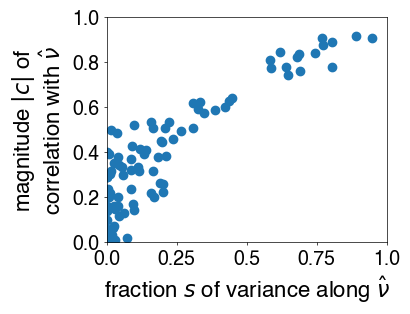

In [39]:
# 2023.4.6 compare correlation coefficients with s statistic
plt.figure(figsize=(4,3))
plt.scatter(sSeries,abs(corrVals_series))
plt.xlabel('fraction $s$ of variance along $\\hat \\nu$')
plt.ylabel('magnitude $|c|$ of \ncorrelation with $\\hat \\nu$')
plt.axis(xmin=0,xmax=1,ymin=0,ymax=1)
plt.subplots_adjust(left=0.25,right=0.95,bottom=0.2,top=0.95)
plt.xticks([0,0.25,0.5,0.75,1],[0.0,0.25,0.5,0.75,1.0])
makePretty()
plt.savefig('230411_c_vs_s.pdf')